Structure tensor analysis (STA) builds a description of a scalar-valued function $f$ (known as the [structure tensor](https://en.wikipedia.org/wiki/Structure_tensor)) in terms of the behavior of its (partial) derivatives at each point. It provides a measure of *anisotropy* ("non-homogeneity") around each point. Taking $f$ to represent an n-dimensional image ($f(x_1, \cdots, x_n)$), structure tensor analysis can provide information about the presence or absence of elongated or similarly oriented structures within the image. This has found use in computer vision and image processing. Notably, the technique has found use in biomedical image analysis, for example [in validating data obtained by the relatively lower-resolution diffusion magnetic resonance imaging](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4387076/) (a non-invasive procedure) by applying STA to data obtained through the relatively higher-resolution confocal microscopy (which would require more invasive procedures if it could be reasonably performed at all).

I figured it would be a fun exercise to translate my understanding of the theory behind STA into an implementation of STA in Python.

In [1]:
import numpy as np
import seaborn as sns
import PIL
# import matplotlib as mpl
# import scipy
from scipy.signal import windows
from scipy.ndimage.interpolation import shift
from scipy import integrate  # using trapezoidal rule
from skimage.util import view_as_windows
import os

from typing import Callable, Tuple, Dict, Union, Sequence

In [2]:
# make things take less time on my laptop...
def resize_image_to_fit(im: PIL.Image, max_size: int=100) -> PIL.Image:
    """Resize image so that largest dimension is max_size pixels."""
    scale_factor = max_size/max(im.size)
    dims = (scale_factor*np.array(im.size)).astype(int)
    
    scale_method = PIL.Image.ANTIALIAS if scale_factor < 1 else PIL.Image.BILINEAR
    
    return im.resize(dims, resample=scale_method)

In [3]:
### HELPER METHODS ###

def _nd_window(arr: np.array, func: Callable, kwargs: Union[Dict, None]=None) -> np.array:
    """Generalizes 1D window functions to size and dimensionality needed for arr."""

    if not kwargs:
        kwargs = {}

    window = np.ones(shape=arr.shape)
    for (axis, axis_dim) in enumerate(arr.shape):
        temp = func(axis_dim, **kwargs)  # 1-D list
        # build broadcastable array
        for i,_ in enumerate(arr.shape):
            if i != axis:
                temp = np.expand_dims(temp, axis=i)
        window *= temp

    return window

# @staticmethod
def apply_window(arr: np.array, window: np.array, loc: Sequence) -> np.array:
    """Apply window function at specified location (tuple of same size as np.shape)."""
    # move center of window to location, then Hadamard product
    # window is normally in middle of field, so first shift to top-left
    delta = -(np.array(window.shape)/2).astype(int) + loc
    return arr * shift(window, delta)

# @staticmethod
def integrate_array(arr: np.array, func: Callable=integrate.trapz) -> np.float64:
    """Repeatedly apply a 1-D integration method (func) to integrate sample data (arr)."""
    try:
        while True:
            arr = func(arr)
    except IndexError: # trying to integrate a number
        return arr
    
def eigenstuff(arr: np.array) -> Tuple[np.array, np.array]:
    """Return eigenvalues and eigenvectors of arr, sorted from largest eigenvector to smallest."""
    evals, evecs = np.linalg.eig(arr)
    indices = np.argsort(-evals) # argsort goes ascending, so negate values first
    return evals[indices], evecs[indices]

def calc_params(arr: np.array) -> Tuple[float, float, float]:
    """Given array, return its (orientation, coherence, energy)."""
    evals, evecs = eigenstuff(arr)
    O = np.arctan2(evecs[0][1],evecs[0][0]) # orientation of dominant eigenvector
    C = (evals[0]-evals[1])/(evals[0]+evals[1]) # relative anisotropy
    E = np.sum(evals) # trace of matrix is sum of eigenvalues
    return O,C,E



# visualize as an image (as compared to sns.heatmap)
def _standardize(arr: np.array) -> np.array:
    """Convert arr to values in [0,1] (uniform/affine transformation)."""
    arr = arr.astype(float)
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

In [4]:
# wrapper to avoid recomputation for same array/image
class Array(object):
    def __init__(self, arr: np.array) -> None:
        """Wrapper class for np.array when performing structure tensor analysis."""
        self.arr = arr
        self.Dx, self.Dy = Dx, Dy = np.gradient(arr)  # finite-difference method
        self.window = _nd_window(arr, windows.gaussian, {'std':1})  # TODO: allow choice of window
        self.integrands = [Dx*Dx, Dy*Dy, Dx*Dy]
        
    def structure_tensor(self, loc: Tuple) -> np.array:
        """Return structure tensor for array at specified location."""
        integrands = [apply_window(i, self.window, loc) for i in self.integrands]
        xx, yy, xy = (integrate_array(i) for i in integrands)
        return np.array([[xx, xy],[xy,yy]])

In [5]:
def build_anisotropy_arr(arr: np.array) -> Union[np.array, None]:
    """
    Given a 2-D array, return a 3-D array containing the anisotropy information at each point.
    Third dimension indexes anisotropy parameters (orientation, coherence, energy).
    """
    if len(arr.shape) != 2:
        return None
    # TODO: Segment into/work over image patches (huge speedup)
    # generator form of skimage.util.view_as_windows()? (to avoid memory explosion)
    arr_aug = Array(arr)
    res = np.zeros(shape=(*arr.shape, 3))
    
    for index in np.ndindex(arr.shape):
        st = arr_aug.structure_tensor(index)
        res[index] = calc_params(st)
        
    return res

In [6]:
# test = np.random.random((3,6))
# arr_aug = Array(test)
# build_anisotropy_arr(test)

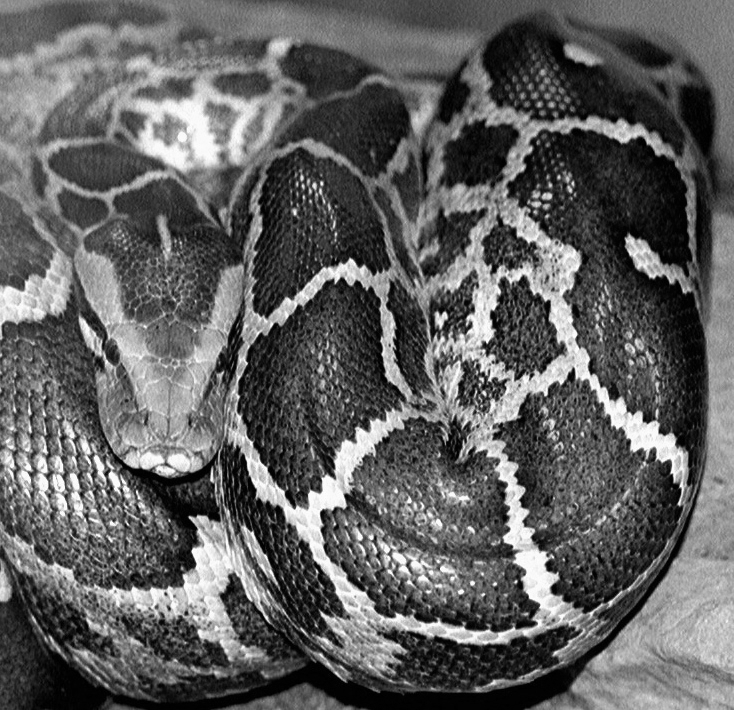

In [7]:
# im = PIL.Image.open('test_image.jpg')  # originally RGB

# image source (CC BY-SA 3.0): https://commons.wikimedia.org/wiki/File:Python_molurus_molurus_2.jpg
im = PIL.Image.open(os.path.join('_assets','img','python.jpg'))  
im = im.convert('L')  # grayscale for structure tensor analysis

im

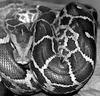

In [8]:
im_fit = resize_image_to_fit(im, max_size=100)  # for my poor laptop's sake...
im_fit

In [9]:
arr = np.array(im_fit)

In [10]:
aniso_arr = build_anisotropy_arr(arr)

In [11]:
# TODO: Decide on a mapping of (O,C,E) -> HSV values to make color image

def make_images_from_arr(arr: np.array) -> Tuple[PIL.Image.Image]:
    """Return grayscale images (orientation, coherence, energy) using the anisotropy array."""
    ims = np.split(aniso_arr, aniso_arr.shape[-1], axis=-1)
    ims = [_standardize(im) for im in ims]
    ims = [(im*255).squeeze().astype(np.uint8) for im in ims]
    ims = [PIL.Image.fromarray(im) for im in ims]
    return ims

In [12]:
orientation, coherence, energy = make_images_from_arr(aniso_arr)

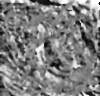

In [13]:
orientation

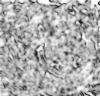

In [14]:
coherence

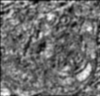

In [15]:
energy

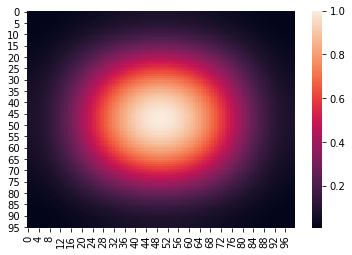

In [16]:
# just for fun

window_ham = _nd_window(arr, np.hamming)
sns.heatmap(window_ham)
# PIL.Image.fromarray((window_ham*255).astype(np.uint8), mode='L')